# Image Denoiser using Autoencoder

*Binary ground truth*

In [1]:
import os
import skimage
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import utils

Using TensorFlow backend.


In [2]:
retrain = False
# If you'd like to retrain (8hrs+), uncomment the following
# retrain = True
model_file = "models/proper_ae_inpaint_model.h5"
folder_path = "data/inpainted_1_5_pairs"
num_samples = 2000
image_dims = (128, 128)

In [3]:
x, y = utils.import_dataset(folder_path, num_samples, image_dims)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [5]:
y_train.shape, y_test.shape

((1800, 128, 128, 1), (200, 128, 128, 1))

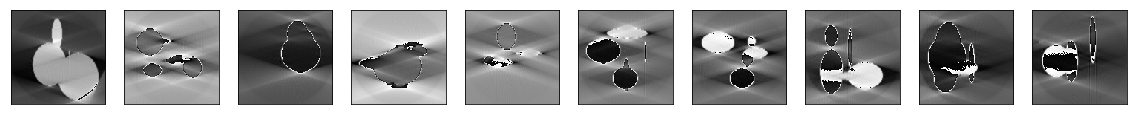

In [6]:
utils.pretty_print(x_test)

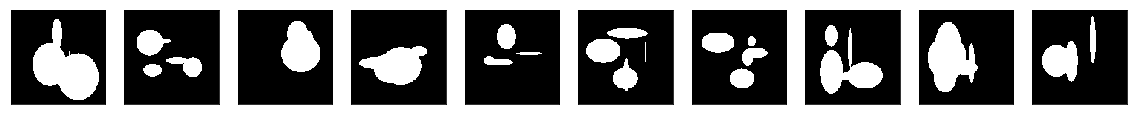

In [7]:
utils.pretty_print(y_test)

## Define Model

In [8]:
input_img = Input(shape=(128, 128, 1)) # x, y, n_channels

# Model Architecture
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


## Train Model

In [9]:
# Define the model checkpoint
filepath = model_file
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [10]:
if retrain:
    autoencoder.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    callbacks=callbacks_list
                   )

## Make Predictions

In [11]:
if retrain:
    predicted_y = autoencoder.predict(x_test)
else:
    new_model = load_model(model_file)
    predicted_y = new_model.predict(x_test)    

Instructions for updating:
Use tf.cast instead.


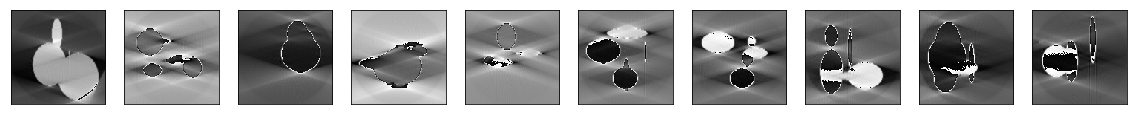

In [12]:
utils.pretty_print(x_test)

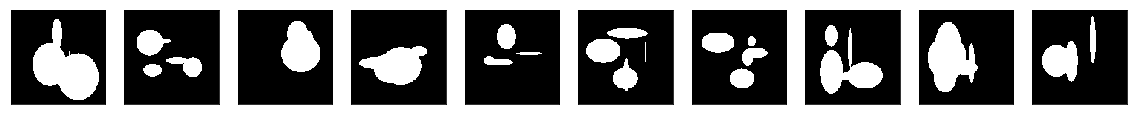

In [13]:
utils.pretty_print(y_test)

PSNR is 17.61
Generic SSIM is 65.85%
Wang SSIM is 64.70%


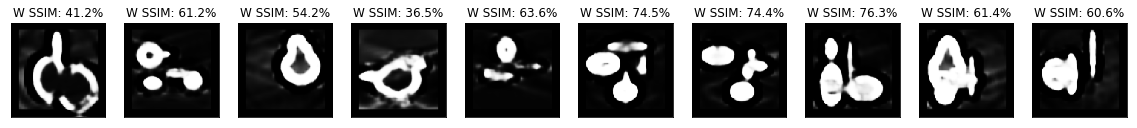

In [14]:
utils.show_results(x_test, y_test, predicted_y)

### Original FBP Results for Comparison

PSNR is 6.57
Generic SSIM is 7.81%
Wang SSIM is 8.45%


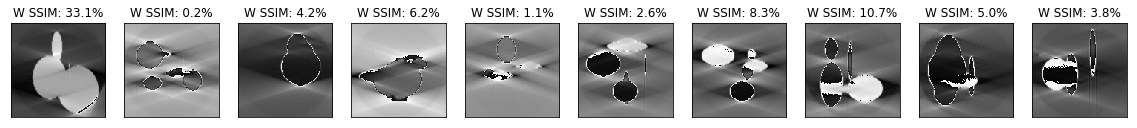

In [15]:
utils.show_results(x_test, y_test, x_test)